### 1. Carga del conjunto de datos

#### 1.1 Instalación de librerias necesarias y lectura de datos de kaggle

Esta fase inical sólo debe ejecutarse una unica vez.

In [3]:
# Instalamos las librerias necesarias
!pip install opencv
!pip install google-colab
!pip install matplotlib
!pip install tensorflow
!pip install scipy
!pip install --upgrade --force-reinstall --no-deps kaggle
!pip install --upgrade kaggle

ERROR: Could not find a version that satisfies the requirement opencv (from versions: none)
ERROR: No matching distribution found for opencv
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 601.3 MB 13 kB/s s eta 0:00:0134 MB 4.6 MB/s eta 0:02:02MB/s eta 0:00:040:04
     |████████████████████████████████| 5.4 MB 29.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 19.0 MB/s eta 0:00:01
     |████████████████████████████████| 5.1 MB 18.8 MB/s eta 0:00:01
     |████████████████████████████████| 80 kB 12.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 23.4 MB/s eta 0:00:01
     |████████████████████████████████| 5.5 MB 28.2 MB/s eta 0:00:01
     |████████████████████████████████| 71 kB 796 kB/s  eta 0:00:01
     |████████████████████████████████| 294 kB 26.8 MB/s eta 0:

In [7]:
# Creamos un directorio en el que copiamos el fichero kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
# Listar los datasets disponibles en kaggle para su descarga
!kaggle datasets list

ref                                                          title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
valakhorasani/mobile-device-usage-and-user-behavior-dataset  Mobile Device Usage and User Behavior Dataset   11KB  2024-09-28 20:21:12          12123        242  1.0              
arslaan5/explore-car-performance-fuel-efficiency-data        Explore Car Performance: Fuel Efficiency Data    5KB  2024-10-17 16:35:59           1160         26  1.0              
hasibur013/diabetes-dataset                                  Diabetes Dataset                                 9KB  2024-10-22 02:10:36            972         28  1.0              
valakhorasani/gym-members-exercise-dataset                   Gym Members Exercise Dataset           

In [9]:
!kaggle datasets download chazzer/smiling-or-not-face-data

Dataset URL: https://www.kaggle.com/datasets/chazzer/smiling-or-not-face-data
License(s): CC0-1.0
 56%|█████████████████████                 | 10.0M/18.0M [00:00<00:00, 34.7MB/s]
100%|██████████████████████████████████████| 18.0M/18.0M [00:00<00:00, 54.3MB/s]


In [20]:
# Definimos ruta del dataset (donde se descargaron las imágenes)
dataset_path = 'my_dataset/'

Ruta pricipal: my_dataset/


In [11]:
# Creemos un directorio para descomprimir los datos con la opción p, si existe no se crea
!mkdir -p $dataset_path

In [12]:
# Descomprimir el archivo ZIP en la carpeta de destino
with zipfile.ZipFile('smiling-or-not-face-data.zip', 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

Dado que para este Dataset de Kaggle dispone de 1203 muestras etiquetadas y 12000 muestras no etiquetadas en la carpeta "test", vamos a copiar el 10% del conjunto de entrenamiento (120 muestras) a la carpeta test_samples y manualmente las vamos a etiquetar moviéndolas a los directorios "smile" y "non_smile". 

In [ ]:
# Definir la ruta de la carpeta de origen y destino
dataset_path_org = dataset_path + 'test'
dataset_path_dest = dataset_path + 'test_samples'
dataset_path_test_smile = dataset_path + 'test_samples/smile'
dataset_path_test_non_smile = dataset_path + 'test_samples/non_smile'

# Crear las carpetas si no existen
if not os.path.exists(dataset_path_dest):
  print(f'no existe direcytorio {dataset_path_dest}')
  !mkdir -p $dataset_path_dest
if not os.path.exists(dataset_path_test_smile):
  print(f'no existe direcytorio {dataset_path_test_smile}')
  !mkdir -p $dataset_path_test_smile
if not os.path.exists(dataset_path_test_non_smile):
  print(f'no existe direcytorio {dataset_path_test_non_smile}')
  !mkdir -p $dataset_path_test_non_smile
    
# Obtener una lista de todos los archivos en la carpeta de origen
all_test_files = os.listdir(dataset_path_org)

# Seleccionar 120 archivos al azar
random.seed(42)
random_files = random.sample(all_test_files, 120)

# Copiar los archivos seleccionados a la carpeta de destino
for file in random_files:
    src_path = os.path.join(dataset_path_org, file)
    dst_path = os.path.join(dataset_path_dest, file)
    shutil.copyfile(src_path, dst_path)
    print(f"Archivo copiado: {file}")

# Luego manualmente se etiquetaron las 120 muestras y se movieron a lso directorios "smile" y "non_smile" dentro de la carrpeta "test_samples"

#### 1.2 Importación de todas las librerias necesarias

In [22]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
import zipfile
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import callbacks
from keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam

#### 1.3 Formación del conjunto de datos de entrenamiento

In [2]:
# Definimos una función que separa las imagenes por clases y le agrega una etiqueta de clase

def clasificacion_imagenes(dataset_path):
  classes = ['smile','non_smile'] # Lista de clases específicas (subdirectorios) a considerar
  all_images = []
  all_labels = []
  for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    class_images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
    print(f'Cantidad de imagenes de la clase {class_name} {len(class_images)}')
    all_images.extend(class_images)
    all_labels.extend([class_name] * len(class_images))
  return all_images, all_labels

# Definimos ruta del dataset (donde se descargaron las imágenes)
dataset_path = 'my_dataset/'
print(f'Ruta pricipal: {dataset_path}')

# Listar las subcarpetas en el directorio
subfolders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]

# Obtener la lista de todas las imágenes de entrenamiento y sus etiquetas
all_train_images = []
all_train_labels = []

# Rellenamos la lista con las imagenes y sus clases para el dataframe de entrenamiento y validación
all_train_images, all_train_labels = clasificacion_imagenes(dataset_path)

# Creamos un DataFrame con las rutas de las imágenes y sus etiquetas para el set de entrenamiento
df_train = pd.DataFrame({'filename': all_train_images, 'class': all_train_labels})

# Mezclamos aleatoriamente los datos
df_train = df_train.sample(frac=1).reset_index(drop=True)
print(f'Cantidad total de imagenes {df_train.shape}')

Ruta pricipal: my_dataset/
Cantidad de imagenes de la clase smile 600
Cantidad de imagenes de la clase non_smile 603
Cantidad total de imagenes (1203, 2)


#### 1.4 Formación del conjunto de datos de test

In [3]:
# Obtener la lista de todas las imágenes de entrenamiento y sus etiquetas
all_test_images = []
all_test_labels = []

# Manualmente clasificamos las imagenes de test
dataset_path_test = dataset_path + 'test_samples'
all_test_images, all_test_labels = clasificacion_imagenes(dataset_path_test)

# Creamos un Dataframe con las rutas y etiquetas para el conjunto de test
df_test = pd.DataFrame({'filename': all_test_images, 'class':all_test_labels})

# Mezclamos aleatoriamente los datos
df_test = df_test.sample(frac=1).reset_index(drop=True)

display(len(df_test))

Cantidad de imagenes de la clase smile 38
Cantidad de imagenes de la clase non_smile 82


120

### 2. Inspección del conjunto de datos

my_dataset/non_smile/Anne_Krueger_0001.jpg
True


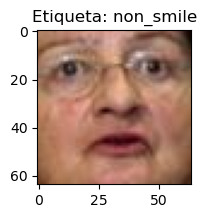

In [4]:
# Definimos una función para mostrar cualquier imagen dada como entrada

def mostrar_muestra(imagen,etiqueta):
    # Esta función recibe una imagen ya sea como "ruta de archivo" o como un "tensor"
    if isinstance(imagen,str): # Es ruta de archivo ?
        img = cv2.imread(imagen, cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else: # Es tensor
        img = imagen
    plt.figure(figsize=(2, 2))
    plt.title(f"Etiqueta: {etiqueta}")
    plt.imshow(img)

idx = np.random.randint(1, 1200)
mostrar_muestra(df_train.iloc[idx,0],df_train.iloc[idx,1])
print(df_train.iloc[idx,0])
print(isinstance(df_train.iloc[idx,0],str))

### 3. Acondicionamiento del conjunto de datos

Debido a que nuestro conjunto de entrenamiento y validación es muy pequeño, sólo disponemos de 1200 muestras; por lo tanto en la formación de nuestros datos vamos con "ImageDataGenerator" de la librería Keras vamos a incluir "DataAugmentation".

In [9]:
# Definimos los parametros iniciales de nuestro generador de datos

img_height = img_width = 64 # Reescalado de la imagen
batch_size = 32
classes = ['smile','non_smile']

# Instanciamos una copia de ImageDataGenerador para el conjunto de datos de entrenamiento aplicando DataAugmentation
train_datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.25)

# Instanciamos una copia de ImageDataGenerador para el conjunto de datos de test
test_datagen = ImageDataGenerator(rescale=1./255)

# Generadores de flujo de datos para conjuntos de entrenamiento, validación y prueba
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='training',
    class_mode='binary')

val_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='validation',
    class_mode='binary')

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=batch_size)

Found 903 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.
Found 120 validated image filenames belonging to 2 classes.


---


# **ESTRATEGIA 1 - FROM SCRACH**


---

### 4. Desarrollo de la arquitectura de red neuronal y entrenamiento de la solución

In [10]:
# Definición de los hiperparámetros

epochs = 20
batch_size = 32

# Instanciamos nuestro modelo Secuencial
modelo_basico = Sequential()

# Definimos el BASE MODEL
# Definimos 2 capas de 64 porque nos da mejores resultados para la extracción de caracteristicas del rostro

modelo_basico.add(layers.Conv2D(128, (3,3),input_shape=(img_width, img_height, 3),padding="same",activation='relu'))
modelo_basico.add(layers.MaxPooling2D(2,2))
modelo_basico.add(layers.Conv2D(64, (3,3),padding="same",activation='relu'))
modelo_basico.add(layers.MaxPooling2D(2,2))
modelo_basico.add(layers.Conv2D(64, (3,3),padding="same",activation='relu'))
modelo_basico.add(layers.MaxPooling2D(2,2))

# Definimos el TOP MODEL

modelo_basico.add(layers.Flatten())
modelo_basico.add(layers.Dense(64,activation='relu'))
modelo_basico.add(layers.Dense(1,activation='sigmoid'))

modelo_basico.summary()

# Compilamos el modelo con los hiperparametros definidos
modelo_basico.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Entrenamos el modelo
his_basico = modelo_basico.fit(train_generator,
                     epochs = epochs,
                     validation_data = val_generator)


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 376,577 (1.44 MB)

 Trainable params: 376,577 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 332ms/step - accuracy: 0.5106 - loss: 0.7021 - val_accuracy: 0.5333 - val_loss: 0.6739
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 321ms/step - accuracy: 0.5339 - loss: 0.6811 - val_accuracy: 0.6667 - val_loss: 0.5333
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 324ms/step - accuracy: 0.7890 - loss: 0.4503 - val_accuracy: 0.8233 - val_loss: 0.3869
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 308ms/step - accuracy: 0.8687 - loss: 0.3049 - val_accuracy: 0.9300 - val_loss: 0.2045
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 323ms/step - accuracy: 0.9233 - loss: 0.2169 - val_accuracy: 0.8867 - val_loss: 0.3079
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 300ms/step - accuracy: 0.9235 - loss: 0.2091 - val_accuracy: 0.9400 - val_loss: 0.1626
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 306ms/step - accuracy: 0.9600 - loss: 0.1302 - val_accuracy: 0.9300 - val_loss: 0.1738
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 309ms/step - accuracy: 0.9396 - loss: 0.1497 - val_accuracy: 0.9467 - val

### 5. Monitorización del proceso de entrenamiento para la toma de decisiones

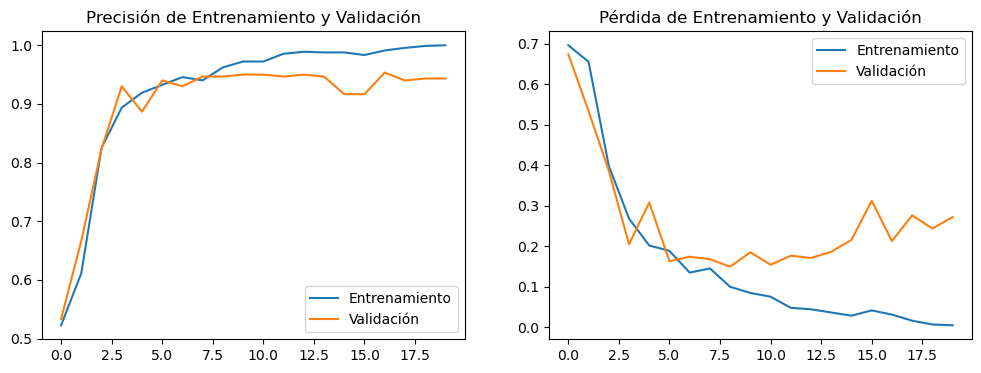

In [11]:
# Preparamos un función que nos ayudara a graficar las curvas de aprendizaje

def grafica_curvas_aprendizaje(history, epocas):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epocas)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Entrenamiento')
    plt.plot(epochs_range, val_acc, label='Validación')
    plt.title('Precisión de Entrenamiento y Validación')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Entrenamiento')
    plt.plot(epochs_range, val_loss, label='Validación')
    plt.title('Pérdida de Entrenamiento y Validación')
    plt.legend(loc='upper right')
    plt.show()

grafica_curvas_aprendizaje(his_basico, 20)

### 6. Evaluación del modelo predictivo y planteamiento de la siguiente prueba experimental

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


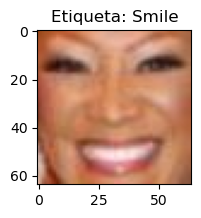

In [12]:
#validation_images, validation_labels = val_generator.next()

sample_image, sample_label = next(val_generator)
predict_label = (modelo_basico.predict(sample_image) > 0.5).astype("int32")
random_index = np.random.randint(0, len(sample_image))  # Índice aleatorio dentro del batch

single_image = sample_image[random_index]
single_label = sample_label[random_index]

mostrar_muestra(single_image,"No smile" if single_label == 0 else "Smile")
#predicted_labels = (modelo.predict(val_generator) > 0.5).astype("int32")



**Análisis**

Apesar de tener valores buenos en la precisión tanto de entrenamiento como validación, sin embargo se observa que a partir de la 8va epoca el modelo presenta sobreajuste pues la curva de pérdida empieza a crecer y separarse de la curva de entrenamiento. Esto puede indicar que el modelo esta aprendiendo características específicas del conjunto de datos de entrenamiento que no generalizan bien al conjunto de datos de validación. Un factor importante es que disponemos de pocas muestras en el dataset, por lo que se propone aplicar los siguientes métodos de regularización:

1. Aumento de Datos mediante la técnica de DataAugmentation.

2. Regularización Adicional: Agregando en cada capa oculta Dropout y Batchnormalization.

3. Programación de la Tasa de Aprendizaje: Mediante callback de reducción de tasa de aprendizaje cuando la métrica de validación deje de mejorar.

4. Incluir callbacks de EarlyStoping y Checkpoint. El primero para deterner el entrenaminto si el modelo empieza a sobreajustar y el segundo para quedarnos con los mejores pesos del modelo en su mejor momento.


#### Creación de nuevo modelo regularizado

In [23]:
# Nuevamente instanciamos una copia de ImageDataGenerador con la configuración de Dataaugmentation reducida
train_datagennew = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  # Rotación aleatoria
    width_shift_range=0.1, # fraccion del total (1) para mover la imagen
    height_shift_range=0.1, # fraccion del total (1) para mover la imagen
    horizontal_flip=True, # girar las imagenes horizontalmente (eje vertical)
    validation_split=0.25
    )

# Generadores de flujo de datos para entrenamiento, validación y prueba
train_generator = train_datagennew.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='training',
    class_mode='binary')

val_generator = train_datagennew.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='validation',
    class_mode='binary')

# Definición de los hiperparámetros

epochs = 30
batch_size = 32

# Instanciamos nuestro modelo
modelo_regularizado = Sequential()

# Definimos el BASE MODEL

modelo_regularizado.add(layers.Conv2D(128, (3,3),input_shape=(img_width, img_height,3), padding="same", activation='relu'))
modelo_regularizado.add(layers.BatchNormalization())
modelo_regularizado.add(layers.MaxPooling2D(2,2))
modelo_regularizado.add(layers.Dropout(0.2))


modelo_regularizado.add(layers.Conv2D(64, (3,3), padding="same", activation='relu'))
modelo_regularizado.add(layers.BatchNormalization())
modelo_regularizado.add(layers.MaxPooling2D(2,2))
modelo_regularizado.add(layers.Dropout(0.2))


modelo_regularizado.add(layers.Conv2D(64, (3,3),padding="same", activation='relu'))
modelo_regularizado.add(layers.BatchNormalization())
modelo_regularizado.add(layers.MaxPooling2D(2,2))
modelo_regularizado.add(layers.Dropout(0.2))


# Definimos el TOP MODEL

modelo_regularizado.add(layers.Flatten())
modelo_regularizado.add(layers.Dense(64, activation='relu'))
modelo_regularizado.add(layers.BatchNormalization())
modelo_regularizado.add(layers.Dropout(0.2))
modelo_regularizado.add(layers.Dense(1, activation='sigmoid'))

modelo_regularizado.summary()

# Compilamos el modelo con los hiperparametros definidos
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
modelo_regularizado.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Definimos nuestros callback
callback_list=[
    callbacks.EarlyStopping(monitor="val_loss",patience=20,restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.6,patience=8,verbose=1,min_lr=0.001),
    callbacks.ModelCheckpoint(filepath='best_model.keras',monitor='val_loss',save_best_only=True)
]

# Entrenamos el model
his_regularizado = modelo_regularizado.fit(train_generator,
                        epochs = epochs,
                        validation_data = val_generator,
                        callbacks=callback_list)

Found 903 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 64, 64, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 377,857 (1.44 MB)

 Trainable params: 377,217 (1.44 MB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/30


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 627ms/step - accuracy: 0.6784 - loss: 0.7053 - val_accuracy: 0.5400 - val_loss: 0.6836 - learning_rate: 0.0010
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 601ms/step - accuracy: 0.8006 - loss: 0.4389 - val_accuracy: 0.5333 - val_loss: 0.7699 - learning_rate: 0.0010
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 620ms/step - accuracy: 0.8560 - loss: 0.3354 - val_accuracy: 0.5367 - val_loss: 0.7071 - learning_rate: 0.0010
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 600ms/step - accuracy: 0.8726 - loss: 0.2950 - val_accuracy: 0.5833 - val_loss: 0.6721 - learning_rate: 0.0010
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 589ms/step - accuracy: 0.8890 - loss: 0.2789 - val_accuracy: 0.6367 - val_loss: 0.6467 - learning_rate: 0.0010
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 628ms/step - accuracy: 0.9047 - loss: 0.2339 - val_accuracy: 0.6433 - val_loss: 0.6259 - learning_rate: 0.0010
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 562ms/step - accuracy: 0.9062 - loss: 0.2560 - val_

#### Monitoreo y evaluación del modelo

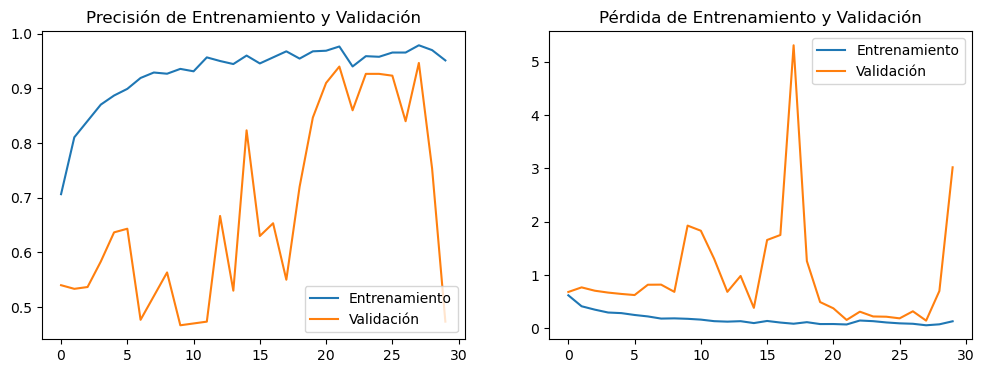

In [24]:
grafica_curvas_aprendizaje(his_regularizado,30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


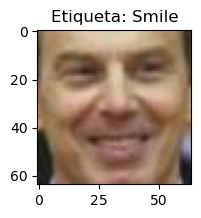

In [56]:
# Usamos las muestras del conjunto de test para predecir resultado

sample_image, sample_label = next(test_generator)
predict_label = (modelo.predict(sample_image) > 0.5).astype("int32")
random_index = np.random.randint(0, len(sample_image))  # Índice aleatorio dentro del batch

single_image = sample_image[random_index]
single_label = sample_label[random_index]

mostrar_muestra(single_image,"No smile" if single_label == 0 else "Smile")
#predicted_labels = (modelo.predict(val_generator) > 0.5).astype("int32")

**Análisis y conclusiones de la primera estrategia**

1. Precisión (Accuracy):

La precisión del entrenamiento es muy buena y se llega a valores sobre el 95%, sin embargo no se observa lo mismo con la precisión de validación que si bien despues de 25 epocas llega a valores moderados sin embargo es muy erratico. 

2. Pérdida (Loss):

La pérdida de entrenamiento decrece de manera significativa y rápida, lo cual es un buen indicador de aprendizaje.
La pérdida de validación sigue una tendencia similar a la de entrenamiento, lo cual es positivo.

3. Generalización:

Dado que aun no se consigue tener cercanía entre las líneas de precisión y pérdida de entrenamiento y validación se determina que el modelo no generaliza del todo bien y aun presenta un ligero sobreajuste.
Pensamos que no se pudo mejorar el sobreajuste debido al pequeño dataset de muestras.

4. Consistencia:

No existe consistencia dado que as líneas de precisión no son bastante suaves, lo que sugiere utilizar técnicas de preentrenado y finetunning.
